In [1]:
'''
code for calculating velocity-velocity correlation function
multipole in real space
'''
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from Corrfunc.theory.DDsmu import DDsmu
from hankel import HankelTransform
from scipy.interpolate import InterpolatedUnivariateSpline as spline 
path ='/Users/ngoc/Desktop/Master-study/project'

In [2]:
#cosmological parameters
z        = 0.306                   #redshift
f        = 0.687255861             #growth rate
Omg_lamb = 0.685                   #dark energy density parameter
Omg_m    = 1. - Omg_lamb           #matter density parameter
a        = 1./(1. + z)             #scale factor
E_a      = np.sqrt(Omg_m*(1.+z)**3. + Omg_lamb) 


In [3]:
#simulation parameters
boxsize  = 2000                    #length of the box [Mpc/h]
nthreads = 4                       #number of Open MP threads to use 
autocorr = 1                       #auto correlation
nbins    = 50                      #number of bins
rmin     = 1.                      #minimum separation [Mpc/h]
rmax     = boxsize/3               #maximum separation [Mpc/h]
bins     = np.logspace(np.log10(rmin), np.log10(rmax), nbins+1)     
mu_max   = 1                       #maximum value of cosine of the angle separated from the LOS
nmu_bins = 10                      #number of bins of the angle separation 
delta_mu = mu_max/nmu_bins
ndata    = 8                       #number of data sets
set_data = "112345678"             #for reading data



In [4]:
A_0 = np.zeros((ndata,nbins))
r_0 = np.zeros((ndata,nbins))
A_2 = np.zeros((ndata,nbins))
A_4 = np.zeros((ndata,nbins))


#Legendre polynomials
P0 = 1
P2 = lambda mu: (3*mu**2-1)/2
P4 = lambda mu: (35*mu**4 - 30*mu**2 + 3)/8 


In [5]:
for i in range (0,ndata):
    # load positions of objects
    X = np.loadtxt(path+'/catalogs/'+set_data[0]+set_data[i+1]+'/gals/2gpc/R1'+set_data[0]+set_data[i+1]+'_S014_clu_d.cat', usecols = (1))
    Y = np.loadtxt(path+'/catalogs/'+set_data[0]+set_data[i+1]+'/gals/2gpc/R1'+set_data[0]+set_data[i+1]+'_S014_clu_d.cat', usecols = (2))
    Z = np.loadtxt(path+'/catalogs/'+set_data[0]+set_data[i+1]+'/gals/2gpc/R1'+set_data[0]+set_data[i+1]+'_S014_clu_d.cat', usecols = (3))

    # load velocities of objects
    V_z     = np.loadtxt(path+'/catalogs/'+set_data[0]+set_data[i+1]+'/gals/2gpc/R1'+set_data[0]+set_data[i+1]+'_S014_clu_d.cat', usecols = (6))
    weights = V_z/(a*E_a*100)
    
    #redshifted along LOS
    s       = Z + V_z/(a*E_a*100) #Z is the LOS 
    for j in range(len(s)):
        if s[j] < 0:
            s[j] = s[j] + boxsize
        elif s[j] > boxsize:
            s[j] = s[j] - boxsize
            
    #calculate random-random pairs 
    N    = len(X)          # number of halos
    RR   = 4./3.*np.pi*(bins[1::]**3 - bins[0:-1:]**3)*N*(N-1)/boxsize**3
    
    # using DDsmu to calculate pair in each mu bin
    results_DDsmu = DDsmu(autocorr, 
                          nthreads,
                          bins,
                          mu_max,
                          nmu_bins,
                          X, Y, s,
                          weights1    = weights,
                          boxsize     = boxsize,
                          weight_type = 'pair_product',
                          output_savg = True,
                          periodic    = True)
  
    npair         = results_DDsmu['npairs']
    weight        = results_DDsmu['weightavg']
    mu            = results_DDsmu['mu_max']
    r_mu          = results_DDsmu['savg']
    DD_r_mu       = npair*weight
      
    #monopole
          
    xi0 = np.zeros(nbins)
    r0  = np.zeros(nbins)
    l   = 0 
    for ii in range(0,nbins):
        for j in range ((ii)*nmu_bins,(ii+1)*nmu_bins):
            xi0[ii] = xi0[ii] + DD_r_mu[j]/(RR[ii]/nmu_bins)*P0*delta_mu    
            r0[ii]  = r0[ii]  + r_mu[j]  
            
    xi0 = (2*l+1)*xi0
    r0  = r0/nmu_bins
    
    A_0[i] = xi0
    r_0[i] = r0
    
 
    #quadrupole
            
    xi2 = np.zeros(nbins)
    l   = 2
    
    for ii in range(0,nbins):
        for j in range ((ii)*nmu_bins,(ii+1)*nmu_bins):
            xi2[ii] = xi2[ii] + DD_r_mu[j]/(RR[ii]/nmu_bins)*delta_mu*P2(mu[j])
   
    xi2    = (2*l+1)*xi2
    A_2[i] = xi2

  
    #hexadecapole
        
    xi4 = np.zeros(nbins)
    l   = 4    
    for ii in range(0,nbins):
        for j in range ((ii)*nmu_bins,(ii+1)*nmu_bins):
            xi4[ii] = xi4[ii] + DD_r_mu[j]/(RR[ii]/nmu_bins)*delta_mu*P4(mu[j])
        
    xi4    = (2*l+1)*xi4 
    A_4[i] = xi4
    


In [6]:
#calculate the mean values and error bars

#monopole
xi_vv0 = np.zeros(nbins)
r_simul  = np.zeros(nbins)

for i in range(0,nbins):
    r_simul[i]  = np.mean(r_0[0:ndata,i])
    xi_vv0[i]   = np.mean(A_0[0:ndata,i])

error_xi_vv0 = np.zeros(nbins) 
for i in range(0,nbins):
    a = 0
    for j in range(0,ndata):
        a = a + (A_0[j,i] - xi_vv0[i])**2.
    error_xi_vv0[i] = np.sqrt(a/(ndata*(ndata-1.)))

#quadrupole
xi_vv2 = np.zeros(nbins)
for i in range(0,nbins):
    xi_vv2[i] = np.mean(A_2[0:ndata,i])

error_xi_vv2 = np.zeros(nbins) 
for i in range(0,nbins):
    a = 0
    for j in range(0,ndata):
        a = a + (A_2[j,i] - xi_vv2[i])**2.
    error_xi_vv2[i] = np.sqrt(a/(ndata*(ndata-1.)))


(1, 864.530427491362)

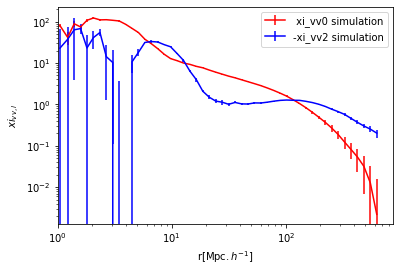

In [7]:
ax = plt.axes()
ax.set_xscale("log")
ax.set_yscale("log")
ax.errorbar(r_simul,  xi_vv0, fmt = 'r-' , yerr = error_xi_vv0, label=' xi_vv0 simulation')
ax.errorbar(r_simul, -xi_vv2, fmt = 'b-' , yerr = error_xi_vv2, label='-xi_vv2 simulation')
ax.set_ylabel("$xi_{vv,l}$")
ax.set_xlabel("r[Mpc$.h^{-1}$]")
ax.legend()
ax.set_xlim(1,)
#ax.set_ylim(-100,500)





In [62]:
# loading matter power spectrum

k   = np.loadtxt(path+'/my_results/matter_Pk.txt', usecols = (0))
P   = np.loadtxt(path+'/my_results/matter_Pk.txt', usecols = (1))
r   = r_simul
P_k = spline(k, P)


In [63]:
# xi_vv monopole

h0    = HankelTransform(nu=1/2, N = 2000, h = 1e-3)

f1    = lambda kk: P_k(kk)/(kk*np.pi*2)**(3/2)

xi_p1 = 1/np.sqrt(r)*h0.transform(f1,r, ret_err=False, inverse=True)   
    
xi_vv0_theory = f**2*xi_p1/3
r_theory      = r

In [64]:
# xi_vv quadrupole

h2    = HankelTransform(nu=5/2, N = 2000, h = 1e-3)

f1    = lambda kk: P_k(kk)/(kk*np.pi*2)**(3/2)

xi_p2 = 1/np.sqrt(r)*h2.transform(f1,r, ret_err=False, inverse=True)

xi_vv2_theory = -2/3*(f)**2*xi_p2


<ipython-input-66-1e639f51c756>:13: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(-1,200)


(0.0009505261013555929, 200)

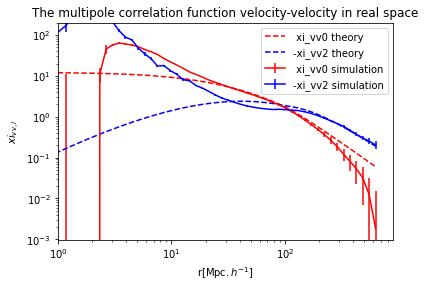

In [66]:
ax = plt.axes()
ax.set_xscale("log")
ax.set_yscale("log")
ax.errorbar(r_simul,  xi_vv0, fmt = 'r-', yerr = error_xi_vv0, label =' xi_vv0 simulation')
ax.errorbar(r_simul, -xi_vv2, fmt = 'b-', yerr = error_xi_vv2, label ='-xi_vv2 simulation')
ax.plot(r_theory,  xi_vv0_theory, 'r--', label =' xi_vv0 theory')
ax.plot(r_theory, -xi_vv2_theory, 'b--', label ='-xi_vv2 theory')
ax.set_ylabel("$xi_{vv,l}$")
ax.set_xlabel("r[Mpc$.h^{-1}$]")
ax.set_title('The multipole correlation function velocity-velocity in real space')
ax.legend()
ax.set_xlim(1,)
ax.set_ylim(-1,200)
#plt.savefig('xi_vv_realspace.png')
